In [1]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import glob,os
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from datetime import timedelta
from datetime import datetime
import tushare as ts
pro = ts.pro_api()

In [2]:
#导入股票交易的文件
path_1 = r'C:\Anaconda\trade_data\stock_trade'
file_1 = glob.glob(os.path.join(path_1, "TRD_Dalyr**.csv"))
file_list_1 = []
for i in file_1:
    fd_file = pd.read_csv(i, index_col=None)
    #剔除B股、科创板；剔除ST股
    fd_file = fd_file.query('Trdsta == 1').query('(Markettype == 1) | (Markettype == 4) | (Markettype == 16)')
    file_list_1.append(fd_file)
fd_stock_trade = pd.concat(file_list_1)

In [3]:
#导入股票指标的文件
path_2 = r'C:\Anaconda\trade_data\stock_ysindex'
file_2 = glob.glob(os.path.join(path_2, 'STK_MKT_DALYR**.csv'))
fd_stock_pb = pd.DataFrame()
for i in file_2:
    fd_file = pd.read_csv(i,index_col=None)
    fd_stock_pb = fd_stock_pb.append(fd_file)
#columns重命名
fd_stock_pb.rename(columns={'Symbol':'Stkcd','TradingDate':'Trddt'},inplace=True)

In [4]:
#合并数据
fd_info = pd.merge(fd_stock_trade,fd_stock_pb,on=['Stkcd','Trddt'],how = 'inner' ) #取交集
fd_info = fd_info.sort_values(['Stkcd','Trddt'])
fd_info['Trddt'] = pd.to_datetime(fd_info['Trddt'])

In [5]:
#对数据进行进一步筛选（次新股、退市公司、缺失值、重复值）
basic_data = pro.stock_basic(exchange='', fields='ts_code,symbol,list_status,list_date')
basic_data['list_date'] = pd.to_datetime(basic_data['list_date'])
basic_data = basic_data.rename(columns={'symbol':'Stkcd'})
basic_data['Stkcd'] = basic_data['Stkcd'].astype('int')
basic_data.drop_duplicates('Stkcd')
fd_new_info = pd.merge(fd_info,basic_data,on = 'Stkcd') #多对一合并
#剔除次新股
fd_new_info['delta'] = fd_new_info['Trddt'] - fd_new_info['list_date']
fd_new_info = fd_new_info[fd_new_info['delta'] > timedelta(120)]
#剔除退市公司
fd_new_info = fd_new_info.query('(list_status == "L")')
#剔除缺失值、重复值
fd_new_info.dropna()
fd_new_info.drop_duplicates(['Stkcd','Trddt'])
fd_new_info = fd_new_info.set_index('Trddt',drop=False)

,Stkcd,Trddt,Dsmvosd,Dretnd,Markettype,Trdsta,ChangeRatio_x,ShortName,PE,PB,Turnover,CirculatedMarketValue,ChangeRatio_y,ts_code,list_status,list_date,delta
Trddt,,,,,,,,,,,,,,,,,
2005-01-04,1,2005-01-04,9189040.01,-0.010622,4,1,-0.010622,深发展A,43.781528,2.708148,0.00125,9.189040e+09,-0.01062,000001.SZ,L,1991-04-03,5025 days
2005-01-05,1,2005-01-05,9104478.29,-0.009202,4,1,-0.009202,深发展A,43.378630,2.683227,0.00229,9.104478e+09,-0.00920,000001.SZ,L,1991-04-03,5026 days
2005-01-06,1,2005-01-06,9189040.01,0.009288,4,1,0.009288,深发展A,43.781528,2.708148,0.00189,9.189040e+09,0.00929,000001.SZ,L,1991-04-03,5027 days
2005-01-07,1,2005-01-07,9174946.39,-0.001534,4,1,-0.001534,深发展A,43.714378,2.703995,0.00134,9.174946e+09,-0.00153,000001.SZ,L,1991-04-03,5028 days
2005-01-10,1,2005-01-10,9287695.35,0.012289,4,1,0.012289,深发展A,44.251575,2.737224,0.00187,9.287695e+09,0.01229,000001.SZ,L,1991-04-03,5031 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,603999,2019-12-25,4412160.00,0.010554,1,1,0.010554,读者传媒,103.882663,2.551035,0.04261,4.412160e+09,0.01055,603999.SH,L,2015-12-10,1476 days
2019-12-26,603999,2019-12-26,4475520.00,0.014360,1,1,0.014360,读者传媒,105.374451,2.587668,0.04157,4.475520e+09,0.01436,603999.SH,L,2015-12-10,1477 days
2019-12-27,603999,2019-12-27,4314240.00,-0.036036,1,1,-0.036036,读者传媒,101.577173,2.494419,0.03717,4.314240e+09,-0.03604,603999.SH,L,2015-12-10,1478 days


In [6]:
#将数据转换为月度数据，并剔除每月交易少于14天的股票
#保留每个月第一天的交易数据（调仓）
fd_trade_month = fd_new_info.groupby(fd_new_info['Stkcd']).resample('M').first()
#剔除每月交易日少于14天的数据
fd_trade_month['count'] = fd_new_info['Trdsta'].groupby(fd_new_info['Stkcd']).resample('M').sum()
fd_trade_month = fd_trade_month[fd_trade_month['count'] > 14]
#计算每个月的收益
fd_new_info['Dretnd'] = fd_new_info['Dretnd'] + 1
fd_trade_month['month_return'] = fd_new_info['Dretnd'].groupby(fd_new_info['Stkcd']).resample('M').prod()
#计算roa
fd_trade_month['ROA'] = fd_trade_month['PB']/fd_trade_month['PE']
fd_trade_month['BM'] = 1/fd_trade_month['PB']
fd_trade_month['EP'] = 1/fd_trade_month['PE']
#生成后续可以使用的月度交易数据
fd_trade_month = fd_trade_month[['Stkcd','Dsmvosd','BM','EP','ROA','month_return','ts_code']]
fd_trade_month.rename(columns={'Stkcd':"stock_id",'Dsmvosd':'MarketValue'},inplace=True)
fd_trade_month

stock_id  MarketValue        BM        EP       ROA  \
Stkcd  Trddt                                                             
1      2005-01-31       1.0   9189040.01  0.369256  0.022841  0.061856   
       2005-03-31       1.0   9019916.58  0.376180  0.023269  0.061856   
       2005-04-30       1.0   7892427.00  0.429919  0.026593  0.061856   
       2005-05-31       1.0   8583014.37  0.395328  0.024453  0.061856   
       2005-06-30       1.0   8385703.69  0.404630  0.025029  0.061856   
...                     ...          ...       ...       ...       ...   
603999 2019-08-31  603999.0   3070080.00  0.563359  0.013834  0.024557   
       2019-09-30  603999.0   3346560.00  0.516816  0.012691  0.024557   
       2019-10-31  603999.0   3340800.00  0.517707  0.012713  0.024557   
       2019-11-30  603999.0   3381120.00  0.511534  0.012562  0.024557   
       2019-12-31  603999.0   3657600.00  0.472867  0.011612  0.024557   

                   month_return    ts_code  
Stkcd  Trddt                                
1      2005-01-31      0.919575  000001.SZ  
       2005-03-31      0.804010  000001.SZ  
       2005-04-30      1.190018  000001.SZ  
       2005-05-31      0.969355  000001.SZ  
       2005-06-30      0.986692  000001.SZ  
...                         ...        ...  
603999 2019-08-31      1.060379  603999.SH  
       2019-09-30      1.005339  603999.SH  
       2019-10-31      1.037170  603999.SH  
       2019-11-30      1.085324  603999.SH  
       2019-12-31      1.154088  603999.SH  

[344056 rows x 7 columns]

In [29]:
#导入市场因子、动量因子、投资因子
fd_five = pd.read_csv('C:/Anaconda/trade_data/five_factor/STK_MKT_FIVEFACMONTH.csv', index_col = None)
fd_five = fd_five[fd_five['Portfolios']==1]
fd_five['TradingMonth'] = pd.to_datetime(fd_five['TradingMonth'])
fd_five.rename(columns = {'TradingMonth':'date'},inplace = True)
fd_five = fd_five.set_index('date')
fd_five = fd_five[datetime(2005,1,1):datetime(2019,12,1)]
fd_five = fd_five.resample('M').last() #index转换为最后一天方便匹配

fd_dl = pd.read_csv('C:/Anaconda/trade_data/five_factor/STK_MKT_CARHARTFOURFACTORS.csv', index_col = None)
fd_dl['TradingMonth'] = pd.to_datetime(fd_dl['TradingMonth'])
fd_dl.rename(columns = {'TradingMonth':'date'},inplace = True)
fd_dl = fd_dl.set_index('date')
fd_dl = fd_dl[datetime(2005,1,1):datetime(2019,12,1)]
fd_dl = fd_dl.resample('M').last() #index转换为最后一天方便匹配

fd_dl_inv = pd.merge(fd_five,fd_dl,how='inner',on='date')
fd_dl_inv = fd_dl_inv[['RiskPremium1','CMA1','UMD1']]
fd_dl_inv

,RiskPremium1,CMA1,UMD1
date,,,
2005-01-31,-0.064116,-0.008636,0.034812
2005-02-28,0.096797,-0.003835,-0.020005
2005-03-31,-0.102522,-0.022821,0.085583
2005-04-30,-0.028775,-0.010890,0.076410
2005-05-31,-0.081724,0.012934,-0.103578
...,...,...,...
2019-08-31,-0.014815,-0.039096,0.044606
2019-09-30,0.005821,-0.013820,-0.014588
2019-10-31,0.013027,-0.017085,0.034106


In [8]:
#定义计算Liu ，Stambaugh and Yuan（2019）三因子，并使用函数封装
def liu3(df_daily):
    df_daily['label_sb3'] = pd.qcut(df_daily['MarketValue'],2,['small','large'])
    df_daily['label_ep3'] = pd.qcut(df_daily['EP'],[0, 0.3, 0.7, 1.0],['low','mid','high'])
    
    #市值和EP双重独立排序
    small_low3 = df_daily.query('(label_sb3 == "small") & (label_ep3 == "low")')
    small_mid3 = df_daily.query('(label_sb3 == "small") & (label_ep3 == "mid")')
    small_high3 = df_daily.query('(label_sb3 == "small") & (label_ep3 == "high")')
    
    large_low3 = df_daily.query('(label_sb3 == "large") & (label_ep3 == "low")')
    large_mid3 = df_daily.query('(label_sb3 == "large") & (label_ep3 == "mid")')
    large_high3 = df_daily.query('(label_sb3 == "large") & (label_ep3 == "high")')
    
    r_sl3 = (small_low3['month_return']*small_low3['MarketValue']).sum()/small_low3['MarketValue'].sum()
    r_sm3 = (small_mid3['month_return']*small_mid3['MarketValue']).sum()/small_mid3['MarketValue'].sum()
    r_sh3 = (small_high3['month_return']*small_high3['MarketValue']).sum()/small_high3['MarketValue'].sum()
    
    r_ll3 = (large_low3['month_return']*large_low3['MarketValue']).sum()/large_low3['MarketValue'].sum()
    r_lm3 = (large_mid3['month_return']*large_mid3['MarketValue']).sum()/large_mid3['MarketValue'].sum()
    r_lh3 = (large_high3['month_return']*large_high3['MarketValue']).sum()/large_high3['MarketValue'].sum()
    
    liu3_smb = (r_sl3+r_sm3+r_sh3-r_ll3-r_lm3-r_lh3)/3
    liu3_hml = (r_lh3+r_sh3-r_ll3-r_sl3)/2
    
    return liu3_smb,liu3_hml

In [9]:
#定义计算Liu，Shi and Lian（2019）四因子，并使用函数封装
def liu4(df_daily):
    df_daily['label_sb4'] = pd.qcut(df_daily['MarketValue'],2,['small','large'])
    df_daily['label_bm4'] = pd.qcut(df_daily['BM'],[0, 0.3, 0.7, 1.0],['low','mid','high'])
    df_daily['label_roa4'] = pd.qcut(df_daily['ROA'],[0, 0.3, 0.7, 1.0],['rlow','rmid','rhigh'])
    
    #市值和BM双重排序
    small_low4 = df_daily.query('(label_sb4 == "small") & (label_bm4 == "low")')
    small_mid4 = df_daily.query('(label_sb4 == "small") & (label_bm4 == "mid")')
    small_high4 = df_daily.query('(label_sb4 == "small") & (label_bm4 == "high")')
    
    large_low4 = df_daily.query('(label_sb4 == "large") & (label_bm4 == "low")')
    large_mid4 = df_daily.query('(label_sb4 == "large") & (label_bm4 == "mid")')
    large_high4 = df_daily.query('(label_sb4 == "large") & (label_bm4 == "high")')
    
    r_sl4 = (small_low4['month_return']*small_low4['MarketValue']).sum()/small_low4['MarketValue'].sum()
    r_sm4 = (small_mid4['month_return']*small_mid4['MarketValue']).sum()/small_mid4['MarketValue'].sum()
    r_sh4 = (small_high4['month_return']*small_high4['MarketValue']).sum()/small_high4['MarketValue'].sum()
    
    r_ll4 = (large_low4['month_return']*large_low4['MarketValue']).sum()/large_low4['MarketValue'].sum()
    r_lm4 = (large_mid4['month_return']*large_mid4['MarketValue']).sum()/large_mid4['MarketValue'].sum()
    r_lh4 = (large_high4['month_return']*large_high4['MarketValue']).sum()/large_high4['MarketValue'].sum()
    
    #市值和ROA双重排序
    small_rlow4 = df_daily.query('(label_sb4 == "small") & (label_roa4 == "rlow")')
    small_rmid4 = df_daily.query('(label_sb4 == "small") & (label_roa4 == "rmid")')
    small_rhigh4 = df_daily.query('(label_sb4 == "small") & (label_roa4 == "rhigh")')
    
    large_rlow4 = df_daily.query('(label_sb4 == "large") & (label_roa4 == "rlow")')
    large_rmid4 = df_daily.query('(label_sb4 == "large") & (label_roa4 == "rmid")')
    large_rhigh4 = df_daily.query('(label_sb4 == "large") & (label_roa4 == "rhigh")')
    
    r_srl4 = (small_rlow4['month_return']*small_rlow4['MarketValue']).sum()/small_rlow4['MarketValue'].sum()
    r_srm4 = (small_rmid4['month_return']*small_rmid4['MarketValue']).sum()/small_rmid4['MarketValue'].sum()
    r_srh4 = (small_rhigh4['month_return']*small_rhigh4['MarketValue']).sum()/small_rhigh4['MarketValue'].sum()
    
    r_lrl4 = (large_rlow4['month_return']*large_rlow4['MarketValue']).sum()/large_rlow4['MarketValue'].sum()
    r_lrm4 = (large_rmid4['month_return']*large_rmid4['MarketValue']).sum()/large_rmid4['MarketValue'].sum()
    r_lrh4 = (large_rhigh4['month_return']*large_rhigh4['MarketValue']).sum()/large_rhigh4['MarketValue'].sum()    
    
    #计算因子收益
    liu4_smb_one = (r_sl4+r_sm4+r_sh4-r_ll4-r_lm4-r_lh4)/3 
    liu4_smb_two = (r_srl4+r_srm4+r_srh4-r_lrl4-r_lrm4-r_lrh4)/3
    liu4_smb = ( (r_sl4+r_sm4+r_sh4-r_ll4-r_lm4-r_lh4)/3 + (r_srl4+r_srm4+r_srh4-r_lrl4-r_lrm4-r_lrh4)/3 ) /2
    liu4_hml = (r_lh4+r_sh4-r_ll4-r_sl4)/2
    liu4_rmw = (r_lrh4+r_srh4-r_lrl4-r_srl4)/2
    
    return liu4_smb,liu4_hml,liu4_rmw

In [10]:
#计算Liu ，Stambaugh and Yuan（2019）三因子
liu3_data = []
for date,group in fd_trade_month.groupby('Trddt'):
    liu3_smb, liu3_hml = liu3(group)
    liu3_data.append([date, liu3_smb, liu3_hml])

In [11]:
#计算Liu，Shi and Lian（2019）四因子
liu4_data = []
for date,group in fd_trade_month.groupby('Trddt'):
    liu4_smb, liu4_hml, liu4_rmw = liu4(group)
    liu4_data.append([date, liu4_smb, liu4_hml, liu4_rmw])

In [31]:
df_liu3 = pd.DataFrame(np.array(liu3_data),columns=['date','liu3_smb', 'liu3_hml'])
df_liu4 = pd.DataFrame(np.array(liu4_data),columns = ['date', 'liu4_smb', 'liu4_hml', 'liu4_rmw'])
df_factor = pd.merge(df_liu3,df_liu4,how='inner',on='date')
df_factor = df_factor.set_index(df_factor['date'])
df_factor

,date,liu3_smb,liu3_hml,liu4_smb,liu4_hml,liu4_rmw
date,,,,,,
2005-01-31,2005-01-31,-0.019483,0.026252,-0.023252,-0.002033,0.023745
2005-03-31,2005-03-31,-0.016479,0.052399,-0.021324,-0.025188,0.061425
2005-04-30,2005-04-30,-0.04353,0.08065,-0.052022,-0.027534,0.091803
2005-05-31,2005-05-31,0.047539,-0.044811,0.042038,0.056065,-0.066786
2005-06-30,2005-06-30,0.005677,0.03408,-0.000153,-0.013415,0.03141
...,...,...,...,...,...,...
2019-08-31,2019-08-31,-0.017565,-0.04336,-0.00258,-0.074335,0.024281
2019-09-30,2019-09-30,0.018557,0.007501,0.017154,-0.00505,0.018054
2019-10-31,2019-10-31,-0.019399,-0.01298,-0.016219,-0.011348,0.00328


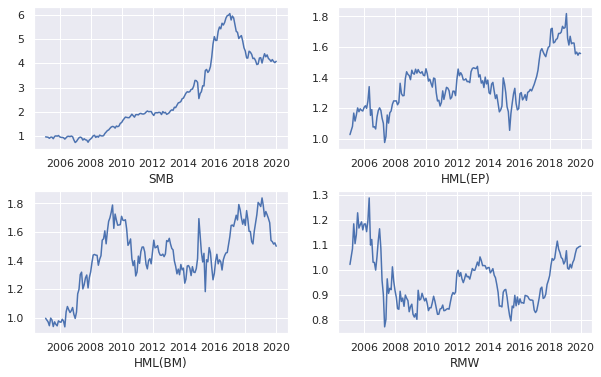

In [46]:
#画出因子的累计收益率
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,2,1)
ax1.plot((pd_factor['liu3_smb']+1).cumprod())
ax1.set_xlabel('SMB')
ax2 = fig.add_subplot(2,2,2)
ax2.plot((pd_factor['liu3_hml']+1).cumprod())
ax2.set_xlabel('HML(EP)')
ax3 = fig.add_subplot(2,2,3)
ax3.plot((pd_factor['liu4_hml']+1).cumprod())
ax3.set_xlabel('HML(BM)')
ax4 = fig.add_subplot(2,2,4)
ax4.plot((pd_factor['liu4_rmw']+1).cumprod())
ax4.set_xlabel('RMW')
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

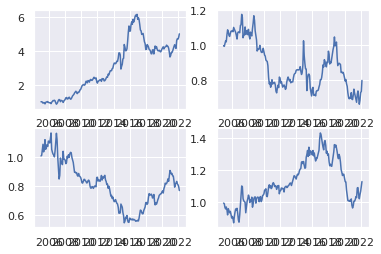

In [15]:
#使用异象检验Liu ，Stambaugh and Yuan（2019）三因子模型和Liu，Shi and Lian（2019）四因子模型效率(以投资和动量为例)
df_test = pd.merge(df_factor,df_dl_inv,how='inner',on='date')


In [16]:
#模型之间的对比（GRS检验）


,Stkcd,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,Msmvosd,Msmvttl,Ndaytrd,Mretwd,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month_return
Trdmnt,,,,,,,,,,,,,,,,,
2005-01,1,4,6.590,31,6.060,57657415,3.645764e+08,8540733.51,11791682.22,19,-0.080425,-0.080425,4,2004-12-30,NaN,NaN,0.919575
2005-02,1,1,6.070,28,6.480,67333734,4.421792e+08,9132665.53,12608927.53,13,0.069307,0.069307,4,2004-12-30,NaN,NaN,1.069307
2005-03,1,1,6.480,31,5.210,80760247,4.738155e+08,7342775.84,10137733.40,23,-0.195988,-0.195988,4,2004-12-30,NaN,NaN,0.804012
2005-04,1,1,5.200,29,6.200,407877006,2.621468e+09,8738044.18,12064097.32,20,0.190019,0.190019,4,2004-12-30,NaN,NaN,1.190019
2005-05,1,9,6.230,31,6.010,126624828,7.768119e+08,8470265.41,11694391.12,17,-0.030645,-0.030645,4,2004-12-30,NaN,NaN,0.969355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,900957,1,0.594,30,0.532,2911853,1.596825e+06,97888.00,185668.00,22,-0.111854,-0.111853,2,2000-08-03,0.0,0.0,0.888146
2019-09,900957,2,0.523,30,0.584,4438806,2.525641e+06,107456.00,203816.00,20,0.097745,0.097744,2,2000-08-03,0.0,0.0,1.097745
2019-10,900957,8,0.583,31,0.574,3500069,2.082744e+06,105616.00,200326.00,18,-0.017121,-0.017123,2,2000-08-03,0.0,0.0,0.982879


,Stkcd,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,Msmvosd,Msmvttl,Ndaytrd,Mretwd,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month_return
Trdmnt,,,,,,,,,,,,,,,,,
2005-01,1,4,6.590,31,6.060,57657415,3.645764e+08,8540733.51,11791682.22,19,-0.080425,-0.080425,4,2004-12-30,NaN,NaN,0.919575
2005-02,1,1,6.070,28,6.480,67333734,4.421792e+08,9132665.53,12608927.53,13,0.069307,0.069307,4,2004-12-30,NaN,NaN,1.069307
2005-03,1,1,6.480,31,5.210,80760247,4.738155e+08,7342775.84,10137733.40,23,-0.195988,-0.195988,4,2004-12-30,NaN,NaN,0.804012
2005-04,1,1,5.200,29,6.200,407877006,2.621468e+09,8738044.18,12064097.32,20,0.190019,0.190019,4,2004-12-30,NaN,NaN,1.190019
2005-05,1,9,6.230,31,6.010,126624828,7.768119e+08,8470265.41,11694391.12,17,-0.030645,-0.030645,4,2004-12-30,NaN,NaN,0.969355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,900957,1,0.594,30,0.532,2911853,1.596825e+06,97888.00,185668.00,22,-0.111854,-0.111853,2,2000-08-03,0.0,0.0,0.888146
2019-09,900957,2,0.523,30,0.584,4438806,2.525641e+06,107456.00,203816.00,20,0.097745,0.097744,2,2000-08-03,0.0,0.0,1.097745
2019-10,900957,8,0.583,31,0.574,3500069,2.082744e+06,105616.00,200326.00,18,-0.017121,-0.017123,2,2000-08-03,0.0,0.0,0.982879


,MarkettypeID,Portfolios,RiskPremium1,SMB1,HML1,RMW1,CMA1
TradingMonth,,,,,,,
2005-01-01,P9709,1,-0.064116,0.000155,-0.004076,0.007324,-0.008636
2005-02-01,P9709,1,0.096797,0.003963,-0.003690,0.004178,-0.003835
2005-03-01,P9709,1,-0.102522,-0.021365,0.014179,0.037717,-0.022821
2005-04-01,P9709,1,-0.028775,-0.063232,0.016615,0.036151,-0.010890
2005-05-01,P9709,1,-0.081724,0.037082,-0.004529,-0.048030,0.012934
...,...,...,...,...,...,...,...
2021-11-01,P9709,1,0.014603,0.112850,-0.051947,0.014427,-0.026230
2021-12-01,P9709,1,0.017494,0.022037,0.034156,-0.020211,0.025542
2022-01-01,P9709,1,-0.081060,-0.004561,0.064478,-0.008470,0.019955


Stkcd      Trddt     Dsmvosd    Dretnd  Markettype  \
Stkcd  Trddt                                                               
1      2005-01-31       1.0 2005-01-04  9189040.01  0.989378         4.0   
       2005-02-28       1.0 2005-02-01  8583014.37  1.004950         4.0   
       2005-03-31       1.0 2005-03-01  9019916.58  0.987654         4.0   
       2005-04-30       1.0 2005-04-01  7892427.00  1.074856         4.0   
       2005-05-31       1.0 2005-05-09  8583014.37  0.982258         4.0   
...                     ...        ...         ...       ...         ...   
603999 2019-08-31  603999.0 2019-08-01  3070080.00  1.005660         1.0   
       2019-09-30  603999.0 2019-09-02  3346560.00  1.033808         1.0   
       2019-10-31  603999.0 2019-10-08  3340800.00  1.026549         1.0   
       2019-11-30  603999.0 2019-11-01  3381120.00  1.001706         1.0   
       2019-12-31  603999.0 2019-12-02  3657600.00  0.998428         1.0   

                   Trdsta  ChangeRatio_x ShortName         PE        PB  \
Stkcd  Trddt                                                              
1      2005-01-31     1.0      -0.010622      深发展A  43.781528  2.708148   
       2005-02-28     1.0       0.004950      深发展A  40.894096  2.529543   
       2005-03-31     1.0      -0.012346      深发展A  42.975733  2.658305   
       2005-04-30     1.0       0.074856      深发展A  37.603766  2.326017   
       2005-05-31     1.0      -0.017742      深发展A  40.894096  2.529543   
...                   ...            ...       ...        ...       ...   
603999 2019-08-31     1.0       0.005660      读者传媒  72.283890  1.775067   
       2019-09-30     1.0       0.033808      读者传媒  78.793508  1.934923   
       2019-10-31     1.0       0.026549      读者传媒  78.657891  1.931593   
       2019-11-30     1.0       0.001706      读者传媒  79.607211  1.954905   
       2019-12-31     1.0      -0.001572      读者传媒  86.116829  2.114761   

                   Turnover  CirculatedMarketValue  ChangeRatio_y    ts_code  \
Stkcd  Trddt                                                                   
1      2005-01-31   0.00125           9.189040e+09       -0.01062  000001.SZ   
       2005-02-28   0.00151           8.583014e+09        0.00495  000001.SZ   
       2005-03-31   0.00239           9.019917e+09       -0.01235  000001.SZ   
       2005-04-30   0.00497           7.892427e+09        0.07486  000001.SZ   
       2005-05-31   0.00688           8.583014e+09       -0.01774  000001.SZ   
...                     ...                    ...            ...        ...   
603999 2019-08-31   0.01322           3.070080e+09        0.00566  603999.SH   
       2019-09-30   0.03384           3.346560e+09        0.03381  603999.SH   
       2019-10-31   0.01039           3.340800e+09        0.02655  603999.SH   
       2019-11-30   0.01038           3.381120e+09        0.00171  603999.SH   
       2019-12-31   0.01626           3.657600e+09       -0.00157  603999.SH   

                  list_status  list_date     delta  
Stkcd  Trddt                                        
1      2005-01-31           L 1991-04-03 5025 days  
       2005-02-28           L 1991-04-03 5053 days  
       2005-03-31           L 1991-04-03 5081 days  
       2005-04-30           L 1991-04-03 5112 days  
       2005-05-31           L 1991-04-03 5150 days  
...                       ...        ...       ...  
603999 2019-08-31           L 2015-12-10 1330 days  
       2019-09-30           L 2015-12-10 1362 days  
       2019-10-31           L 2015-12-10 1398 days  
       2019-11-30           L 2015-12-10 1422 days  
       2019-12-31           L 2015-12-10 1453 days  

[387594 rows x 17 columns]